In [272]:
import numpy as np
import pandas as pd

- I don't think we even need pandas
- we just could work with 2D array 
- read text from .txt file and store into a 2D-array

## without using pandas read_ tables

In [273]:
cols=['variance','skewness','curtosis','entropy-of-image','class']
# convert into csv without pandas read_table
with open('datasets/data_banknote_authentication.txt') as r:
    lines=r.readlines()
    csvList=[]
    for line in lines:
        line=line.strip('\n').split(',')
        lineList=[float(l) for l in line[:-1]]
        lineList.append(int(line[-1]))
        csvList.append(lineList)
data=pd.DataFrame(csvList,columns=cols)

## Part(a)
#### Code up the perceptron algorithm described on slide 7 of Lecture 15 using the same notation as in the slides.  [10 points]

- what does using the same notatoin means

In [274]:
np.random.seed(1)
'''
possible to give x,y in one 2D array then some indexing changes needs to be done
input: 
output: perceptron learned weight vector
'''
def percep(feature_data,labels,margin=0,learn_rate=1,n_iter=100):
    # convert class labels into +1/-1
    # 0 --> -1
    # 1 --> +1

    class_label=[]
    for c in labels:
        if c==0:
            class_label.append(-1)
        else:
            class_label.append(1)
    # print(class_label)
    # get feature length and total no of samples
    N,d=feature_data.shape

    # intialize w
    # with w=zeros it get stuck in the for loop
    w=np.ones(d)
    t=0
    # for loop
    for i in range(n_iter):
        # If `high` is None (the default), then results are from [0, `low`).
        '''rand=np.random.randint(N)
        curr_x=feature_data[rand]
        curr_y=class_label[rand]
        if (curr_y*np.dot(w.T,curr_x)<0):
            w=w+curr_x*curr_y
        else:'''
        while(True):
            rand=np.random.randint(N)
            curr_x=feature_data[rand]
            curr_y=class_label[rand]

            if (curr_y*np.dot(w.T,curr_x)<margin): # margin =0(default)
                w=w+curr_x*curr_y*learn_rate # learn_rate=1(default)
                # print(f'mistake -- {w}')
                break
    return w

In [275]:
y=np.array(data['class'])
f=np.array(data.drop('class',axis=1))
w=percep(f,y,n_iter=1000)

## Part(b)

#### Write functions to make predictions using the algorithm for the banknotes dataset. Preprocess the dataset to handle missing and anomalous data

### read data

In [276]:
# easy way to get txt into csv using pandas read_table
cols=['variance','skewness','curtosis','entropy-of-image','class']
data=pd.read_table('datasets/data_banknote_authentication.txt',sep=',',names=cols)

#### handle missing and anomalous data

In [277]:
data.isnull().sum()

variance            0
skewness            0
curtosis            0
entropy-of-image    0
class               0
dtype: int64

- no missing data in banknote dataset

- how to detect anomalies
    - box plot gives away curtosis and entropy-of-image outliers[25-75]

<AxesSubplot:>

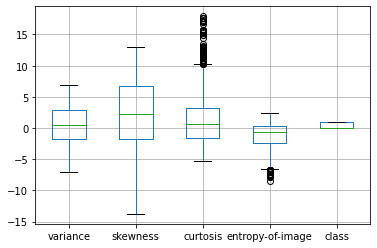

In [278]:
data.boxplot()

array([[<AxesSubplot:title={'center':'curtosis'}, xlabel='[class]'>,
        <AxesSubplot:title={'center':'entropy-of-image'}, xlabel='[class]'>],
       [<AxesSubplot:title={'center':'skewness'}, xlabel='[class]'>,
        <AxesSubplot:title={'center':'variance'}, xlabel='[class]'>]],
      dtype=object)

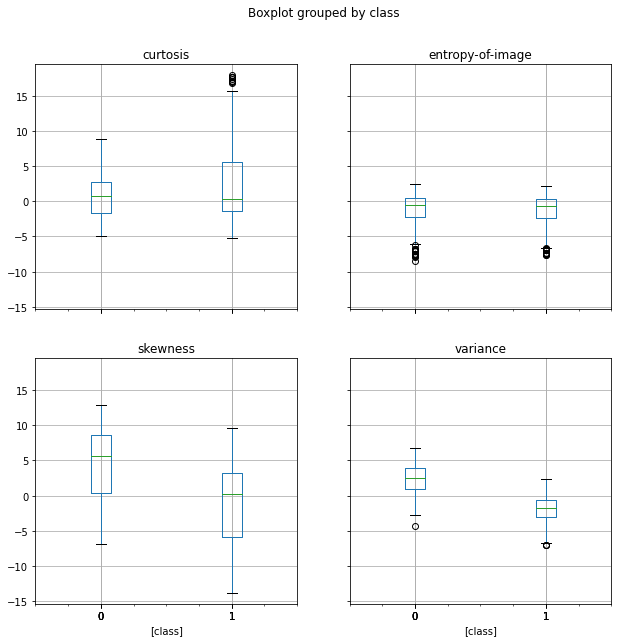

In [279]:
data.boxplot(by='class',figsize=(10,10))

### predict and f1-score func

In [280]:
def predict(x,w):
    pred=np.dot(w.T,x)
    if pred > 0:
        return 1
    else:
        return 0

In [281]:
# both inputs are lists
def f1_score(y_true,y_pred):
    # initiate variables
    tp=0
    fp=0
    fn=0
    for i in range(len(y_pred)):
        if y_pred[i]==y_true[i] and y_true[i]==1:
            tp+=1
        elif y_true[i]==1 and y_pred[i]==0:
            fn+=1
        elif y_true[i]==0 and y_pred[i]==1:
            fp+=1
    # calculate stats
    p=tp/(tp+fp)
    r=tp/(tp+fn)
    f1=(2*p*r)/(p+r)

    return round(f1,3) # round up-to only 3 decimal points

In [282]:
y_pred=[predict(p,w) for p in f]

In [283]:
print(f'F1 Score is >> {f1_score(y,y_pred)}')

F1 Score is >> 0.919


## Part(c)

#### Train the algorithm on the dataset using cross-validation and report cross-validated test set error 

In [284]:
# data is with features and labels
# in fact we don't need to give it data; just total no of obeservations should suffice

def k_fold_splitter(obs_no,k=10,random_state=1):
    
    np.random.seed(random_state)

    points=list(range(obs_no))
    np.random.shuffle(points)

    factor=obs_no//k

    k_fold_list=list()
    # k-1 folds are of equal size
    # fold count starts from 0 and goes upto (k-1)
    for i in range(k-1):
        for j in range(factor):
            k_fold_list.append((points[j],i))
    
    counted_no=len(k_fold_list)
    # laskt fold holds everything that is remaining
    for i in range(obs_no-len(k_fold_list)):
        k_fold_list.append((points[i+counted_no],k-1))
    return k_fold_list

#### cross validation set f1 scores

In [285]:
folds=10
split_tuple_list=k_fold_splitter(data.shape[0],k=folds,random_state=10)

In [293]:
f1_list=list()
weight_list=list()
for i in range(folds):

    fold_point_list=[]
    test_point_list=[]
    for point in split_tuple_list:
        if point[1]!=i:
            fold_point_list.append(point[0])
        else:
            test_point_list.append(point[0])
    # print(fold_point_list)
    # print(len(fold_point_list) ,'||', len(test_point_list))

    train_fold_data=data.iloc[fold_point_list,:]
    train_y=list(train_fold_data['class'])
    train_x=np.array(train_fold_data.drop('class',axis=1))

    test_fold_data=data.iloc[test_point_list,:]
    test_y=list(test_fold_data['class'])
    test_x=np.array(test_fold_data.drop('class',axis=1))

    w=percep(train_x,train_y) # with default values
    weight_list.append(w)
    
    y_pred=[predict(new_point,w) for new_point in test_x]

    f1=f1_score(test_y,y_pred)
    f1_list.append(f1)

    print(f'F1 score for fold {str(i+1)} is {f1}')


F1 score for fold 1 is 0.93
F1 score for fold 2 is 0.948
F1 score for fold 3 is 0.939
F1 score for fold 4 is 0.938
F1 score for fold 5 is 0.948
F1 score for fold 6 is 0.966
F1 score for fold 7 is 0.914
F1 score for fold 8 is 0.948
F1 score for fold 9 is 0.948
F1 score for fold 10 is 0.916
avg F1 score for all folds is 9.395


In [296]:
# The average of your k recorded errors/scores is called the cross-validation error/score and will serve as performance metric for the model
print(f'avg F1 score(cross-validation score) for all folds is {sum(f1_list)/folds}')

avg F1 score for all folds is 0.9395


## Part(d)

#### Ensure you use a held out validation set and report F1 score on the held out set for your best model